# Clustering: Below-Phoneme

Import libraries and helpers

In [6]:
import os, sys

import lib.clustering.clustering_metrics

directory = os.path.abspath('/Users/joris/Documents/Work/bsc ai/bt/Bachelor-Thesis/code')
sys.path.append(directory)

from dataset.loading import DataLoader
from lib.plotting.plot_1 import *
from lib.esn import ESN
from lib.clustering.clustering_metrics import *
from experiments.exp2_below_phoneme_clustering.kmeans.kmeans import KMeans
from experiments.exp2_below_phoneme_clustering.kmeans.method import *
from experiments.helpers.experiment_helpers import *

import numpy as np
import random
import warnings
import pandas as pd

np.random.seed(0)
random.seed(0)
warnings.filterwarnings("ignore")

#### Data
Collect the training dataset.
It is restricted to 50 speakers of equal male-female distributions and only contains "SX" (phonetically diverse) sentences. The data are pre-processed into 10 steps long 14-mffc signals with 39 phoneme labels.

In [7]:
save = True

data_path = '../../../'
cache_dir = '../../cache/'
dl = DataLoader(data_path, cache_dir)

dr = []
descriptions = dl.read_descriptions("Train")
descriptions['gender'] = descriptions.speaker_id.str[0]
descriptions = descriptions.groupby("speaker_id").first().reset_index() # Remove duplicate speakers
descriptions = descriptions.groupby(["dialect_region", "gender"]).sample(4, replace=False).reset_index() #get 4 Males and 4 Females from each dr
speakers = descriptions.speaker_id.values
sentence = "SX"

XorZ = "X"
long_version = False
n_mels = 14
delta = False
delta_delta = False
subsamples = 10
const_params = {
    "n_mels":n_mels,
    "XorZ":XorZ,
    "N":100
}

path_option = "Final"+str(long_version)+str(n_mels)+str(delta)+str(delta_delta)+str(subsamples)

if dr:
    path_option = str(dr)+path_option
if len(speakers):
    path_option = str(len(speakers))+path_option
if sentence:
    path_option = sentence+path_option

features,labels,oversamplings = dl.collectFeaturesInSegments(
    n_mels=n_mels,delta=delta,delta_delta=delta_delta,
    long_version=long_version,speakers=speakers,dr=dr,
    sentence=sentence,subsamples=subsamples,path_option=path_option)

-from output
---- success


Regroup data and label arrays into a phoneme-keyed dictionary. Then, select only a subset of the phonemes and randomly sample them down to an equal number samples per phoneme.

In [8]:
from dataset.data_processing import *

#selected_labels = None
selected_labels = ["aa", "b", "l", "iy", "f", "p", "g"]

#selected_labels = ["aa", "b", "s", "iy", "f", "p", "g", "r", "w"]
#selected_labels = ["aa", "ae", "ah", "eh", "ih", "iy", "uh"]
#selected_labels = ['ih', 'r', 'uh', 'eh', 'l', 'ae', 'er', 'aa', 'aw', 'iy', 'ey', 'oy', 'ah', 'y']

minn = 15

phonemes, features, labels, features_test, labels_test = filter_data(features, labels, selected_labels=selected_labels, limit=minn, test=True)
group = group_by_labels(features, labels)
n_samples = len(features)
n_classes = len(phonemes)

correct_assignments = [ [] for _ in range(n_classes) ]
idx = 0
for i, phoneme in enumerate(group.keys()):
    for _ in group[phoneme]:
        correct_assignments[i].append(idx)
        idx += 1

print(f"{str(len(features_test))} test samples")
print(f"{str(n_classes)} phonemes: {phonemes}")

Filtered to 105 samples of shape (10, 14)
1759 test samples
7 phonemes: ['b', 'l', 'aa', 'iy', 'f', 'p', 'g']


#### Experiments pre-steps
Initialize the ESN with the parameters found in experiment 1.

In [9]:
XorZ = "X"

esn_params = {
    "in_dim": n_mels*(1+delta+delta_delta),
    "out_dim": n_mels*(1+delta+delta_delta),
    "N": 100,
    "W_in_scale": 1.1,
    "b_scale": .6,
    "spectral_radius": 2.57,
    "weights": .1
}

esn = ESN(esn_params)

esn_states = [ esn.run(feature.T, XorZ=XorZ) for feature in features ]

Compute a conceptor for each sample.
Currently, these are used for clustering only in the condition that uses conceptor similarity as the distance function.

In [10]:
save = False
aperture = "auto"
normalize = True

Cs = compute_Cs(signals=features, esn=esn, aperture=aperture, normalize=normalize, XorZ=XorZ, cache=save, file_identifier=path_option)
target_sum = np.mean([sum_of_singular_vals(C) for C in Cs])
print(target_sum)

Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  27.345440784034885
normalizing
Target:  7.967525624984721
std 0.41986450906570927
7.967367417365204


#### Clustering

##### Single run
An example run with the similarity-based condition and random initialization.

In [11]:
#method = Method.CONCEPTOR_SIM
#method = Method.STATE_EUCLIDIAN
#method = Method.SIGNALS_EUCLIDIAN
method = Method.CONCEPTOR_PRED
#method = Method.CONCEPTOR_FROB
#method = Method.CONCEPTOR_SPECTRAL
#method = Method.PRED_CENTROIDS

import importlib
import experiments.exp2_below_phoneme_clustering.kmeans.kmeans
importlib.reload(experiments.exp2_below_phoneme_clustering.kmeans.kmeans)
from experiments.exp2_below_phoneme_clustering.kmeans.kmeans import KMeans

nb_clusters = len(selected_labels)

km = KMeans(method, Cs=Cs, signals=features, esn_states=esn_states, XorZ=XorZ, target_sum=target_sum)

centroids, clusters, ds_hist, cluster_hist, centroid_hist = km.k_means(nb_clusters=nb_clusters, max_epochs=100, init_clusters="random", save=False, debug=True)

Running KMeans: 'random' initialization | Method.CONCEPTOR_PRED method | 7 clusters.
Epoch 0 # centroids: 7
Epoch 1 # centroids: 7
Epoch 2 # centroids: 7
Epoch 3 # centroids: 7
Epoch 4 # centroids: 7
Epoch 5 # centroids: 7
Epoch 6 # centroids: 7
Epoch 7 # centroids: 7
Epoch 8 # centroids: 7
Converged


Evaluation of the single run:

1. The Normalized Mutual Information (NMI) for evaluating how well clusters matched the original classes on a range between 0 (no overlaps) and 1 (perfect match)
2. The (Simplified) Silhouette Coefficient (SC) for evaluating the cohesiveness of the clusters, i.e., the mean difference between intra-cluster and inter-cluster distances, on a range between -1 and 1, where a high value corresponds to highly cohesive clusters.

Caution for interpretation: The SC is dependent on the distance function for its computation potentially prioritizing some distance functions.

--------------truth--------------
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  153.12564999232043
normalizing
Target:  49.75363571833014
std 2.1580234794583624
- computing negative conceptors
Test Accuracy Dataset     : 0.7111995451961342
Dataset NMI:  1.0
Dataset Lengths:  [15, 15, 15, 15, 15, 15, 15]
--------------kmeans--------------
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  108.98932303980189
normalizing
Target:  46.62031062523359
std 5.274902461353825
- computing negative conceptors
Test Accuracy Kmeans     : 0.43035815804434335
Kmeans NMI:  0.41060069414628786
Kmeans Lengths:  [6, 9, 31, 20, 10, 14, 15]
--------------random--------------
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  125.78879244559816
normalizing
Target:  50.16874312125447
std 0.6709223410521866
- computing negative conceptors
Test Accuracy random     : 0.28140989198

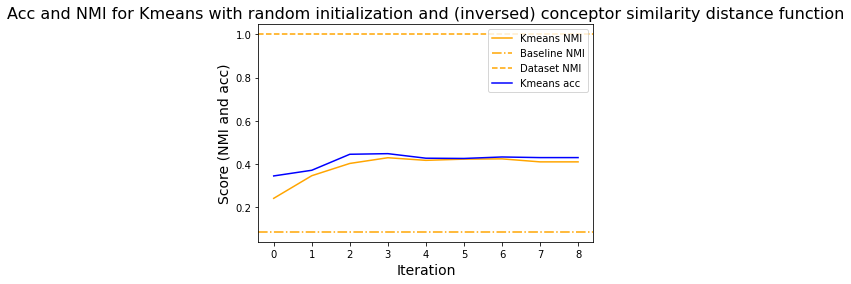

In [12]:
# Converting the clusters to an index-based representation
assignment_hist = km.cluster_to_assignment_repr_l(cluster_hist)
assignments_kmeans = assignment_hist[-1]

# Ground truth
print('--------------truth--------------')
correct_clusters = km.assignment_to_cluster_repr(correct_assignments)
nmi_truth = NMI(correct_assignments, correct_assignments)

acc_truth = clas_acc(correct_clusters, correct_clusters, phonemes, features_test, labels_test)
print(f'Test Accuracy Dataset     : {acc_truth}')
print("Dataset NMI: ", nmi_truth)
print("Dataset Lengths: ", [len(x) for x in correct_assignments])

# Kmeans
print('--------------kmeans--------------')
nmi_kmeans = NMI(assignments_kmeans, correct_assignments)
acc_kmeans = clas_acc(clusters, correct_clusters, phonemes, features_test, labels_test)
print(f'Test Accuracy Kmeans     : {acc_kmeans}')

print("Kmeans NMI: ", nmi_kmeans)
print("Kmeans Lengths: ", [len(x) for x in assignments_kmeans])

# Random
print('--------------random--------------')
clusters_random = km.init_random(len(clusters))
assignments_random = km.cluster_to_assignment_repr(clusters_random)
nmi_baseline = NMI(assignments_random, correct_assignments)
acc_baseline = clas_acc(clusters_random, correct_clusters, phonemes, features_test, labels_test)

print(f'Test Accuracy random     : {acc_baseline}')
print("Baseline NMI: ", nmi_baseline)
print("Baseline Lengths: ", [len(x) for x in assignments_random])

NMI_list = NMIs_from_list(assignment_hist, correct_assignments)
acc_list = clas_acc_from_list(cluster_hist, correct_clusters, phonemes, features_test, labels_test)

def plot_progress(NMI_list, acc_list, title=''):
    plt.figure()
    plt.plot(NMI_list, color="orange", label="Kmeans NMI")
    plt.axhline(y=nmi_baseline, color='orange', linestyle='dashdot', label="Baseline NMI")
    plt.axhline(y=nmi_truth, color='orange', linestyle='dashed', label="Dataset NMI")
    plt.plot(acc_list, color="blue", label="Kmeans acc")
    plt.legend()
    plt.xlabel('Iteration', fontsize=14)
    plt.ylabel('Score (NMI and acc)', fontsize=14)
    plt.title(title, fontsize=16)
    plt.show()

plot_progress(NMI_list, acc_list, title="Acc and NMI for Kmeans with random initialization and (inversed) conceptor similarity distance function")

#### Comparative Experiment

In [ ]:
def experiment(repetitions=2, cluster_numbers=[n_classes]):
    params = {
        "method" : [Method.SIGNALS_EUCLIDIAN, Method.STATE_EUCLIDIAN, Method.CONCEPTOR_PRED, Method.PRED_CENTROIDS, Method.CONCEPTOR_PRED_CS_ONLY],
        "init_clusters" : ["smart", "random"]
    }
    results = []
    for method in params["method"]:
        for init in params["init_clusters"]:
            for n_clusters in cluster_numbers:
                NMIs = []
                accs = []
                ds = []
                print(f"Method: {method}, Cluster initialization: {init}, #clusters: {n_clusters}")
                for _ in range(repetitions):
                    km = KMeans(method, Cs=Cs, signals=features, esn_states=esn_states, XorZ=XorZ, target_sum=target_sum)
                    centroids, clusters, ds_hist, cluster_hist,_ = km.k_means(
                        nb_clusters=n_clusters, max_epochs=100, init_clusters=init, save=False, debug=False
                    )
                    assignment_hist = [ km.cluster_to_assignment_repr(cluster) for cluster in cluster_hist ]

                    # Results
                    NMIs.append(NMIs_from_list(assignment_hist, correct_assignments))
                    accs.append(clas_acc_from_list(cluster_hist, correct_clusters, phonemes, features_test, labels_test))
                    ds.append(km.intra_dist_mean_from_list(cluster_hist))

                results.append( {
                    "method": method,
                    "init_clusters": init,
                    "n_clusters": n_clusters,
                    "NMIs": NMIs,
                    "mean_NMI": np.mean([ n[-1] for n in NMIs ]),
                    "accs": accs,
                    "mean_acc": np.mean([ a[-1] for a in accs ]),
                    "ds": ds,
                    "mean_ds": np.mean([ d[-1] for d in ds ])
                } )
    return results

cluster_numbers = range(1, 18, 1)
results = experiment(repetitions=20)

Method: Method.SIGNALS_EUCLIDIAN, Cluster initialization: smart, #clusters: 7
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  135.40648671324468
normalizing
Target:  40.40104092049951
std 8.930773958530894
- computing negative conceptors
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  95.24532558808343
normalizing
Target:  43.216603192354924
std 6.118060459065795
- computing negative conceptors
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  98.69865599118437
normalizing
Target:  44.628635169733776
std 5.869784146496795
- computing negative conceptors
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  104.01657081244367
normalizing
Target:  46.0326556027433
std 5.813758481125302
- computing negative conceptors
Number of samples: 105
Computing conceptors...
optimizing
Computing gammas...
Optimal gamma:  108.3

 Extract the NMIs and SCs from the results for display.

In [ ]:
nmis = {}
accs = {}
ds = {}
nmis_runs = {}# runs with correct number of classes
accs_runs = {}
ds_runs = {}

def trial_name(result):
    return result["method"].name + " " + result["init_clusters"]

for entry in results:
    name = trial_name(entry)
    if name not in nmis.keys():
        nmis[name] = []
        accs[name] = []
        ds[name] = []
        nmis_runs[name] = []
        accs_runs[name] = []
        ds_runs[name] = []
    nmis[name].append(entry["mean_NMI"])
    accs[name].append(entry["mean_acc"])
    ds[name].append(entry["mean_ds"])
    if entry["n_clusters"] == n_classes:
        nmis_runs[name] += entry["NMIs"]
        accs_runs[name] += entry["accs"]
        ds_runs[name] += entry["ds"]

Print the best results and plot the scores by cluster number

In [ ]:
# plot_NMIs = Plot()
# plot_NMIs.inc(ylabel="NMI score", xlabel="k clusters")
# plot_accs = Plot()
# plot_accs.inc(ylabel="SC score", xlabel="k clusters")
cluster_numbers = [n_classes]

print("Mean NMI scores:")
for name, nmi in nmis.items():
    print(f"{name}: {np.mean(nmi)} at k={cluster_numbers[np.argmax(nmi)]} clusters")
#     plot_NMIs.add(nmi,x=cluster_numbers, label=name)
# print("Random clusters:", nmi_baseline)
# print("Dataset: ", nmi_truth)

print("Mean ACC:")
for name, acc in accs.items():
    print(f"{name}: {np.mean(acc)} at k={cluster_numbers[np.argmax(acc)]} clusters")
    # plot_accs.add(acc,x=cluster_numbers, label=name)
# print("Random clusters:", acc_baseline)
# print("Dataset SC: ", acc_truth)
# plot_NMIs.finalize("NMIs for different k's across conditions")
# plot_accs.finalize("NMIs for different k's across conditions")
print("Mean D:")
for name, d in ds.items():
    print(f"{name}: {np.mean(d)} at k={cluster_numbers[np.argmax(d)]} clusters")
    # plot_accs.add(acc,x=cluster_numbers, label=name)
# print("Random clusters:", acc_baseline)
# print("Dataset SC: ", acc_truth)
# plot_NMIs.finalize("NMIs for different k's across conditions")
# plot_accs.finalize("NMIs for different k's across conditions")

Plot progress over kmeans iterations with k=7 clusters.

In [ ]:
# TODO: SEPARATE PLOTS
title="NMI progress for Kmeans with k=7 clusters."
plt.figure(figsize=(10,8))

#names = ["Control", "Conceptor"]
# SCs
for (name, nmis_run) in nmis_runs.items():
    for nmis_r in nmis_run:
        plt.plot(nmis_r, label="Kmeans: "+name)
plt.axhline(y=nmi_baseline, color='black', linestyle='dashdot', label="Random")
plt.axhline(y=nmi_truth, color='green', linestyle='dashed', label="Dataset")

# Legend
plt.legend(title="NMI", title_fontsize=16, fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('NMI', fontsize=16)
plt.show()

In [ ]:
# TODO: SEPARATE PLOTS
title="ACC Progress with K=7 Clusters."
plt.figure(figsize=(10,8))

#names = ["Control", "Conceptor"]
# SCs
for (name, accs_run) in accs_runs.items():
    for accs_r in accs_run:
        plt.plot(accs_r, label="Kmeans: "+name)
plt.axhline(y=acc_baseline, color='black', linestyle='dashdot', label="Random")
plt.axhline(y=acc_truth, color='green', linestyle='dashed', label="Dataset")

# Legend
plt.legend(title="SC", title_fontsize=16, fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('SC', fontsize=16)
plt.show()

In [ ]:

title="D Progress with K=7 Clusters."
plt.figure(figsize=(10,8))

#names = ["Control", "Conceptor"]
for (name, ds_run) in ds_runs.items():
    for ds_r in ds_run:
        plt.plot(ds_r, label="Kmeans: "+name)

# Legend
plt.legend(title="D", title_fontsize=16, fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('D', fontsize=16)
plt.show()

In [ ]:
title="ACC Progress with K=7 Clusters."
plt.figure(figsize=(14,12))

names = ["Control", "Conceptor"]
# SCs
max_len = max(max(len(accs_r) for accs_r in accs_run) for name, accs_run in accs_runs.items())  # find the longest sequence
for name, accs_run in accs_runs.items():
    # Pad sequences with NaNs
    padded_accs = [np.pad(accs_r, (0, max_len - len(accs_r)), constant_values=np.nan) for accs_r in accs_run]
    # Compute average
    avg_accs = np.nanmean(padded_accs, axis=0)
    plt.plot(avg_accs, label="Kmeans: "+name)
plt.axhline(y=acc_baseline, color='black', linestyle='dashdot', label="Random")
plt.axhline(y=acc_truth, color='green', linestyle='dashed', label="Dataset")

# Legend
plt.legend(title="SC", title_fontsize=16, fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('SC', fontsize=16)
plt.show()

In [ ]:
title="NMI Progress with K=7 Clusters."
plt.figure(figsize=(14,12))

names = ["Control", "Conceptor"]
# SCs
max_len = max(max(len(nmis_r) for nmis_r in nmis_run) for name, nmis_run in nmis_runs.items())  # find the longest sequence
for name, nmis_run in nmis_runs.items():
    # Pad sequences with NaNs
    padded_nmis = [np.pad(nmis_r, (0, max_len - len(nmis_r)), constant_values=np.nan) for nmis_r in nmis_run]
    # Compute average
    avg_nmis = np.nanmean(padded_nmis, axis=0)
    plt.plot(avg_nmis, label="Kmeans: "+name)
plt.axhline(y=nmi_baseline, color='black', linestyle='dashdot', label="Random")
plt.axhline(y=nmi_truth, color='green', linestyle='dashed', label="Dataset")

# Legend
plt.legend(title="NMI", title_fontsize=16, fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('NMI', fontsize=16)
plt.show()

In [ ]:
title="D Progress with K=7 Clusters."
plt.figure(figsize=(10,8))

names = ["Control", "Conceptor"]
# SCs
max_len = max(max(len(ds_r) for ds_r in ds_run) for name, ds_run in ds_runs.items())  # find the longest sequence
for name, ds_run in ds_runs.items():
    # Pad sequences with NaNs
    padded_ds = [np.pad(ds_r, (0, max_len - len(ds_r)), constant_values=np.nan) for ds_r in ds_run]
    # Compute average
    avg_ds = np.nanmean(padded_ds, axis=0)
    plt.plot(avg_ds, label="Kmeans: "+name)

# Legend
plt.legend(title="SC", title_fontsize=16, fontsize=16)
plt.xlabel('Iteration', fontsize=16)
plt.ylabel('SC', fontsize=16)
plt.show()